# Generative MNIST model using PyTorch

## Contents

1. [Background](#Background)
1. [Goal](#GoalB)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background
**Model**: Ever heard about *Generative Adversarial Model* (GAN) ? How about *DeepFakes*? Many generative models nowadays use typical GAN architecture to model data distribution, then reconstruct and generate a completely new data.

We have seen many application of GAN such as face generation and face morphing. The underlying model behind GAN architecture that enables its generative capability is called *Variational Autoencoder* (VAE). Today we are going to take a look on how to build a simple Conditional VAE model.

**Dataset**: MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits).


## Goal
This tutorial will show you how to build and deploy on Sagemaker using Pytorch. The dataset we are using is the MNIST dataset. To get the feel, we will first see how a simple neural network can be used to generate a new handwritten digit image without human intervension. Then we will train and deploy our Pytorch model in Sagemaker environment.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---


---

## Setup 
_(Duration: 5 min)_

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).

---


In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/workshop-pytorch-mnist'

role = sagemaker.get_execution_role()

### Packages

We will also setup our project by specifying libraries and modules that we need

In [ ]:
import os, sys
import json, logging, argparse

import numpy as np

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# visualisation
import matplotlib.pyplot as plt

%matplotlib inline

Markdown settings for table display:

In [20]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

## Load Data: MNIST
_(Duration: 10 min)_


Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

### Pulling MNIST data

In [6]:
# specify where to download MNIST data
data_dir = 'data/'

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-10,10)),
    transforms.ToTensor(),
])

# choose the training and test datasets
train_data = datasets.MNIST(data_dir, train=True, transform=transform, download=True)
test_data = datasets.MNIST(data_dir, train=False, transform=transform, download=True)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Visualize a Batch of Training Data
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

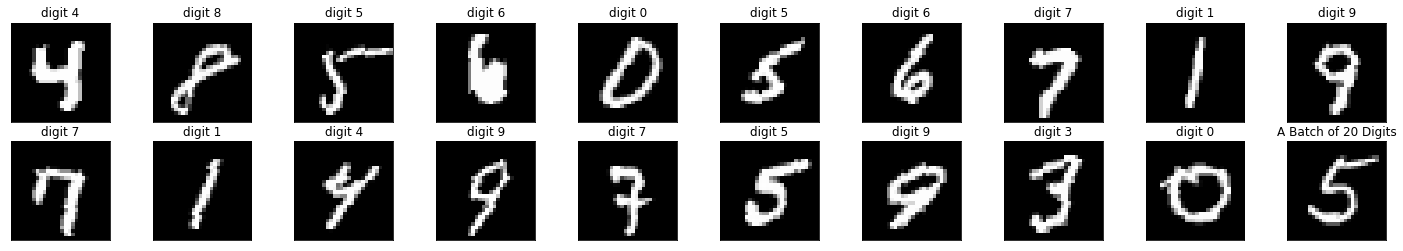

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title('digit ' + str(labels[idx].item()))  # .item() gets single value in scalar tensor

### Visualise Image in detail

Now let's see an image from MNIST dataset in detail. Notice how our image pixels only ranges from $(0, 1)$. This means that no further normalisation is required in the preprocessing step.

Text(0.5, 1.0, 'MNIST Digit in detail')

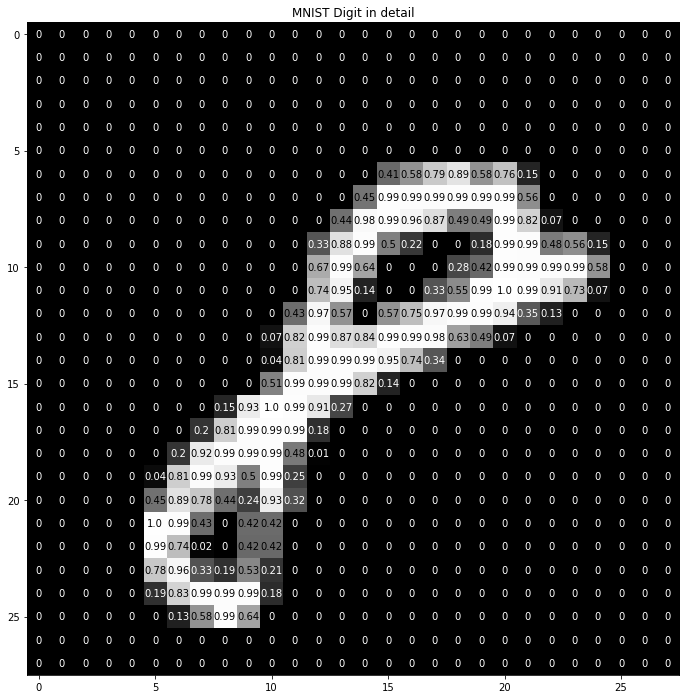

In [15]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

ax.set_title('MNIST Digit in detail');

### Uploading the data to S3
Next, we are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [16]:
s3_data_path = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('Data path/url in AWS S3 -> {}'.format(s3_data_path))

Data path/url in AWS S3 : s3://sagemaker-ap-southeast-1-352716015230/sagemaker/workshop-pytorch-mnist


## Model Definition: CVAE Neural Network
_(Duration: 25 min)_

The Conditional Variational Autoencoder (CVAE) architecture will be responsible for seeing input of $784$-dim Tensor of pixel values for each image and $10$-dim Tensor of our label's onehot encoding representation. Our VAE architecture consisted of $7$ hidden layers. each layer is a linear layer with `Weight` and `bias` parameters. 

Through those parameters, the encoder part of our CVAE model will learn how to decompose an digit image into a latent vector $Z$ of $75$-dim by using the input image from our dataset. We also allow our model to be conditioned for which number we want to generate the image. This is done by passing the labels as part of the input along with our image.

Finally our decoder will take the latent vector $Z$ and learn how to re-generate a dataset that is close to the original dataset, but it has little variant in it. The decoder part enables our model to generate a new MNIST digit that is quite similar to the digit in our dataset.

Our CVAE model follows the bayesian formulation of VAE as described in the [original paper](https://arxiv.org/pdf/1812.04405) conditioned on additive information (in our case, the classification label of our data). Checkout the original paper if you're interested in the mathematics behind CVAE and how it empowered many application in real world.

In VAE there are two modules:

- Encoder: $Q_\phi(Z_i | X_i)$
- Decoder: $P_\theta(X_i|Z_i)$

### Encoder Module

We define our Encoder $Q_\phi(Z_i | X_i)$ layer as follows:



Layer name           |Configuration| 
:---                 |:---         |
input_layer          | FC-794      |
hidden_layer_0       | FC-512      | 
hidden_layer_1       | FC-128      |  
hidden_layer_2       | FC-128      | 
bottle_neck_layer    | FC-75       |

Our MNIST image is $28 \times 28$. When we flatten the image, it becomes a  long vector of $784$-dim. We concatenate this vector with onehot encoding of our label which is a $10$-dim vector

In between each layer, we will use *Rectified Linear unit* (ReLU) as our activation function. ReLU is defined mathematically as follows:

In [24]:
class Encoder(nn.Module):
    """ Encoder module of simple Conditional VAE network
    """

    def __init__(self, input_dim, latent_dim, num_classes=10):
        """ Initialise Encoder component of CVAE
        """
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Initialise first hidden layer
        self.hidden_layer_0 = nn.Linear(input_dim, 512)    # TODO: specify hidden layer 0
        self.hidden_layer_1 = nn.Linear(512, 128)          # TODO: specify hidden layer 1
        self.hidden_layer_2 = nn.Linear(128, 128)          # TODO: specify hidden layer 2

        # Bottle neck layers
        self.mu_layer = nn.Linear(128, latent_dim)         # TODO: specfiy bottle-neck layer
        self.logvar_layer = nn.Linear(128, latent_dim)     # TODO: specify bottle-neck layer


    def forward(self, x):
        # Input x shape: [batch_size, input_dim + num_classes]
        x = x.view(-1, self.input_dim + self.num_classes)

        x = F.relu(self.hidden_layer_0(x))
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))

        # Latent space parametric variables
        z_mu = self.mu_layer(x)
        z_logvar = self.logvar_layer(x)

        return z_mu, z_logvar

### Decoder Module

We define our Decoder Decoder $P_\theta(X_i|Z_i)$ layer as follows:


Layer name           |Configuration|
:---                 |:---         |
hidden_layer_3       | FC-128      |
hidden_layer_4       | FC-128      |
hidden_layer_5       | FC-512      |
reconstruction_layer | FC-784      |

In [25]:
class Decoder(nn.Module):
    """ Decoder module for Conditional VAE network
    """

    def __init__(self, input_dim, latent_dim, num_classes=10):
        """ Initialise Decoder component of CVAE
        Arguments:
        ------------------------
            .. input_dim (int)   - input channel of data X, the length of flattened image vector
            .. latent_dim (int)  - length of latent dim vector in bottle neck layer
            .. num_classes (int) - number of classes/target groups in dataset
        """
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Initialise first hidden layer
        self.hidden_layer_3 = nn.Linear(input_dim, 128)    # TODO: specify hidden layer 3
        self.hidden_layer_4 = nn.Linear(128, 128)          # TODO: specify hidden layer 4
        self.hidden_layer_5 = nn.Linear(128, 512)          # TODO: specify hidden layer 5

        # Recontruction layer
        self.recontruction_layer = nn.Linear(512, input_dim)

    def forward(self, z):
        # Latent variable z shape: [batch_size, latent_dim + num_classes]
        x = z.view(-1, self.latent_dim + self.num_classes)

        # Forward flow to hidden layers
        x = F.relu(self.hidden_layer_3(x))
        x = F.relu(self.hidden_layer_4(x))
        x = F.relu(self.hidden_layer_5(x))

        # Recontructed input image
        generated_x = F.sigmoid(self.recontruction_layer(x))

        return generated_x

### Conditional VAE Module

Now that we have defined the Encoder and Decoder, let’s combine them into our Conditional VAE:

In [26]:
class CVAE(nn.Module):
    """ Conditional VAE (Variational Autoencoder)
    """

    def __init__(self, input_dim, latent_dim, num_classes):
        """ Initialise Decoder component of CVAE
        Arguments:
        ------------------------
            .. input_dim (int) - input channel of data X, the length of flattened image vector
            .. latent_dim (int) - length of latent dim vector in bottle neck layer
            .. num_classes (int) - number of classes/target groups in dataset
        """
        super().__init__()

        self.encoder = CEncoder(input_dim, latent_dim, num_classes)
        self.decoder = CDecoder(torch_mnist/input_dim, latent_dim, num_classes)

    def forward(self, x, y):
        # Concatenate image x and label y
        x = torch.cat((x, y), dim=1)

        # Learn latent Z distribution parameter
        z_mu, z_logvar = self.encoder(x)

        # Resampling using reparameterisation trick
        std = torch.exp(z_logvar / 2)
        eps = torch.randn_like(std)
        sampled_z = eps * std + z_mu
        
        z = torch.cat((sampled_z, y), dim=1)

        # Recontruct image x
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_logvar

## Train model

## Train Session in Cloud
*(Duration: 20 min)*

### Training script
The `mnist.py` script provides all the code we need for training and hosting a SageMaker model (`model_fn` function to load a model).
The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's `fit()` method, the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

For the script run by this notebook:

In [28]:
!pygmentize entrypoint.py

import os, sys
import json, logging, argparse

import torch
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

from torchvision import datasets, transforms

from torch_mnist.model import CVAE
from torch_mnist.utils_vae import (
    target_to_onehot, calculate_vae_loss,
    img_tile
)

torch.manual_seed(42)
if torch.cuda.is_available:
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))


# -------------------------
# TRAINING HELPER
# -------------------------

def _average_gradients(model):
    # Gradient averaging.
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM)
        param.gr

### Pytorch Distributed Computing in Sagemaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters. In this case we are going to run our training job on 2 ```ml.c4.xlarge``` instances. But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)). The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the `entrypoint.py` script above.


In [48]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='entrypoint.py',    # script for training entrypoint
                    dependencies=['torch_mnist'],   # source code for model and other functionals
                    role=role,
                    framework_version='1.2.0',
                    train_instance_count=2,
                    train_instance_type='ml.c4.xlarge',
                    hyperparameters={
                        'epochs': 3,
                        'backend': 'gloo'
                    })

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.

In [54]:
estimator.fit({'training': s3_data_path})

2020-01-04 12:27:50 Starting - Starting the training job......
2020-01-04 12:28:29 Starting - Launching requested ML instances......
2020-01-04 12:29:33 Starting - Preparing the instances for training......
2020-01-04 12:30:39 Downloading - Downloading input data...
2020-01-04 12:31:15 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-04 12:31:29,594 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-04 12:31:29,597 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-04 12:31:29,608 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-04 12:31:28,615 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-04 12


2020-01-04 12:31:28 Training - Training image download completed. Training in progress.Initialized the distributed environment: 'gloo' backend on 2 nodes. Current host rank is 1. Number of gpus: 0
Preparing training dataloader
Processes 30000/60000 (50%) of train data
Preparing testing dataloader
Processes 10000/10000 (100%) of test data
Train Epoch: 001 [01600/30000 ( 5%)] Loss: 210.8766 0.1845
Train Epoch: 001 [03200/30000 (11%)] Loss: 207.7660 0.2527
Train Epoch: 001 [03200/30000 (11%)] Loss: 209.2525 0.6900
Train Epoch: 001 [04800/30000 (16%)] Loss: 200.9807 1.5022
Train Epoch: 001 [04800/30000 (16%)] Loss: 198.8232 0.9680
Train Epoch: 001 [06400/30000 (21%)] Loss: 195.0504 1.4304
Train Epoch: 001 [06400/30000 (21%)] Loss: 202.7919 1.7416
Train Epoch: 001 [08000/30000 (27%)] Loss: 202.4122 1.9386
Train Epoch: 001 [08000/30000 (27%)] Loss: 177.2846 2.8436
Train Epoch: 001 [09600/30000 (32%)] Loss: 203.7535 2.7941
Train Epoch: 001 [09600/30000 (32%)] Loss: 188.1272 2.5866
Train Epoc


2020-01-04 12:32:32 Uploading - Uploading generated training model
2020-01-04 12:32:32 Completed - Training job completed
Training seconds: 226
Billable seconds: 226


## Host
After training, we use the `PyTorch` estimator object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

As mentioned above we have implementation of `model_fn` in the `mnist.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in `mnist.py`. Here we will deploy the model to a single ```ml.m4.xlarge``` instance.

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

### Evaluate
We can now use this predictor to classify hand-written digits. Drawing into the image box loads the pixel data into a `data` variable in this notebook, which we can then pass to the `predictor`.

In [ ]:
import numpy as np

image = np.array(test_images[0], dtype=np.uint8) / 255
image = image.reshape(1, 1, 28, 28)
response = predictor.predict(image)
prediction = response.argmax(axis=1)[0]
print(prediction)

### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [ ]:
estimator.delete_endpoint()